## data loader

In [9]:
from graphlstm_vae_ad import GraphLSTM_VAE_AD
import pandas as pd
import numpy as np

process = "lammps_27_2500"
duration = "10ms"

DATASET = "/home/sx/MPI_profile/"+ process + "/" + duration + "/node_feature.csv"
TOPOLOGY = "/home/sx/MPI_profile/"+ process + "/" + duration + "/graph_edge"


def data_load(): 
    data = pd.read_csv(DATASET, header=[0,1])
    data.columns.names = ['metric', 'host']
    tempm = data.stack()
    tempm = (tempm-tempm.mean())/(tempm.std())
    metric = tempm.unstack().swaplevel('metric','host',axis=1).stack().unstack()


    edge_data = pd.read_csv(TOPOLOGY, header=0)
    # edge_data = edge_data.groupby(['ts_id','src', 'dst']).agg({'commsize': 'sum'}).reset_index()
    edge_data = edge_data.groupby(['src', 'dst']).agg({'commsize': 'sum'}).reset_index()

    edge_index = edge_data[['src', 'dst']].values.T.tolist()
    edge_weight = edge_data['commsize'].values.tolist()

    # print("metric:")
    # print(metric)

    print("Edge Index:")
    print(edge_index)

    # print("Edge Weight:")
    # print(edge_weight)

    return metric, edge_index


metric, edge_index = data_load()


Edge Index:
[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26], [1, 2, 3, 6, 9, 18, 0, 2, 4, 7, 10, 19, 0, 1, 5, 8, 11, 20, 0, 4, 5, 6, 12, 21, 1, 3, 5, 7, 13, 22, 2, 3, 4, 8, 14, 23, 0, 3, 7, 8, 15, 24, 1, 4, 6, 8, 16, 25, 2, 5, 6, 7, 17, 26, 0, 10, 11, 12, 15, 18, 1, 9, 11, 13, 16, 19, 2, 9, 10, 14, 17, 20, 3, 9, 13, 14, 15, 21, 4, 10, 12, 14, 16, 22, 5, 11, 12, 13, 17, 23, 6, 9, 12, 16, 17, 24, 7, 10, 13, 15, 17, 25, 8, 11, 14, 15, 16, 26, 0, 9, 19, 20, 

## 加载数据与模型

In [10]:
print(len(metric))

3838


In [11]:
# model = GraphLSTM_VAE_AD(sequence_length=120, gpu=1)
model = GraphLSTM_VAE_AD(name=process + "_" + duration, sequence_length=30, hidden_dim=8, batch_size=32, lr=1e-3, num_epochs=500)

## 训练模型

Epoch [86/500], Iter [50/83], total_loss: 8969.0723, recon_loss: 8905.1084, kl_loss: 63.9643
valid_loss: [13319.435574776786, 12950.927064732143, 13256.963922991072, 12620.318861607142, 12327.649860491072, 12140.312248883929, 12023.802036830357, 11898.5896484375, 11885.763197544642, 11819.115764508928, 11719.355552455358, 11693.030440848213, 11586.757310267858, 11531.986495535713, 11591.437834821429, 11301.562165178571, 11221.616880580357, 11221.51953125, 11109.347126116072, 11172.197293526786, 10963.535853794643, 10944.954771205357, 10916.0078125, 10863.901199776787, 10816.424274553572, 10789.418638392857, 10689.705022321428, 10754.771568080358, 10598.807421875, 10699.197349330358, 10587.481361607142, 10475.71010044643, 10526.119559151786, 10288.496456473214, 10255.636411830357, 10209.53501674107, 10153.929771205358, 10110.641322544643, 10052.440904017858, 10059.089174107143, 9989.146372767857, 9966.446316964286, 10025.538560267858, 9903.269447544642, 9841.701255580358, 9856.830803571

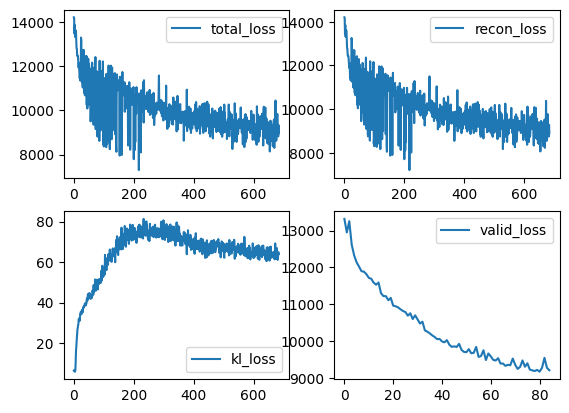

 67%|██████▋   | 56/83 [01:21<00:39,  1.48s/it]

In [12]:
model.fit(metric, 27, edge_index, log_step=10, patience=10)

In [10]:
model.load(16, metric.shape[1])

In [11]:
scores_sum = []
scores_max = []
outputs = []
scores_sum, scores_max, outputs = model.predict(metric, 16, edge_index, 20)

  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [04:22<00:00, 11.92s/it]


In [29]:
print(outputs.shape)

(695, 16, 8)


In [30]:
mylog = open('/home/sx/MPI_profile/lu.C.16/100ms/output.txt', mode = 'a',encoding='utf-8')
for i in range(len(outputs)):
    print(outputs[i], file=mylog)
mylog.close()
# df_outputs = pd.DataFrame(data=outputs)
# df_outputs.to_csv('outputs.csv')
# print(outputs)

In [32]:
mylog = open('/home/sx/MPI_profile/lu.C.16/100ms/scores_sum.txt', mode = 'a',encoding='utf-8')
for i in range(len(scores_max)):
    print(scores_max[i], file=mylog)
mylog.close()

In [ ]:
mylog = open('/home/sx/MPI_profile/lu.C.16/100ms/scores_max.txt', mode = 'a',encoding='utf-8')
for i in range(len(scores_max)):
    print(scores_max[i], file=mylog)
mylog.close()